In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import cv2

### Frequency Domain Image Blur Measure (FM)

In [15]:
def compute_fm_score(image: np.array) -> float:
    # Step 1: Compute F which is the Fourier Transform representation of image I
    f = np.fft.fft2(image)
    # Step 2: Find Fc which is obtained by shifting the origin of F to centre.
    fc = np.fft.fftshift(f)
    # Step 3 Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
    af = np.abs(fc)
    # Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
    m = np.max(af)
    # Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
    threshold = m * 0.001
    th = np.sum(af > threshold)
    # Step 6: Calculate Image Quality measure (FM) from equation (1).
    N, M = image.shape
    return th / (N * M)

In [16]:
def compute_fm(self, image: np.array) -> float:
    # Step 1: Compute F which is the Fourier Transform representation of image I
    f = np.fft.fft2(image)
    # Step 2: Find Fc which is obtained by shifting the origin of F to centre.
    fc = np.fft.fftshift(f)
    # Step 3 Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
    af = np.abs(fc)
    # Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
    m = np.max(af)
    # Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
    threshold = m * 0.001
    th = np.sum(af > threshold)
    # Step 6: Calculate Image Quality measure (FM) from equation (1).
    N, M = image.shape
    return th / (N * M)

In [3]:
class Roi:
    def __init__(self, frame_height: int, frame_width: int, roi: float = 1, height: int = 1, width: int = 1) -> None:
        if roi > 1 or roi <= 0:
            raise ValueError('roi is out of range')

        self.roi = roi
        self.frame_height = frame_height
        self.frame_width = frame_width

        if roi == 1:
            if height > frame_height or width > frame_width:
                raise ValueError('Height/width of the image must be less than the frame height/width')
            self.height = height
            self.width = width
        else:
            # Get height and width
            self.height = int(frame_height * self.roi)
            self.width = int(frame_width * self.roi)

        self.y_start = (frame_height - self.height) // 2
        self.x_start = (frame_width - self.width) // 2

    def apply(self, image: np.array) -> np.array:
        return image[self.y_start:self.y_start + self.height, self.x_start:self.x_start + self.width]

    def get_focus_matrix(self, nrows: int, ncols: int) -> np.array:
        overlay = np.zeros((self.frame_height, self.frame_width, 3), dtype=np.uint8)

        # Calcular el tamaño de cada rectángulo
        rect_width = self.width // (2 * ncols - 1)
        rect_height = self.height // (2 * nrows - 1)

        # Para que los rectangulos esten equidistantes calculamos el margen minimo y ajustamos el lado 
        if rect_width < rect_height:
            margin = rect_width
            rect_height = (self.height - margin * (nrows - 1)) // nrows
        else:
            margin = rect_height
            rect_width = (self.width - margin * (ncols - 1)) // ncols

        # Dibujar la matriz de rectángulos en la capa de superposición
        for i in range(nrows):
            for j in range(ncols):
                # Calcular las coordenadas del rectángulo
                x_start = self.x_start + j * (rect_width + margin)
                y_start = self.y_start + i * (rect_height + margin)

                x_end = x_start + rect_width
                y_end = y_start + rect_height
                # Dibujar los rectángulos en la capa de superposición (con color verde)
                cv2.rectangle(overlay, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)

        return overlay


In [17]:
def convert_to_img(value_list: list, image_shape: tuple, total_frames: int):
    fig, ax = plt.subplots(figsize=(image_shape[0] / 100, image_shape[1] / 100))
    ax.set_xlim(0, total_frames + total_frames * 0.1)
    ax.scatter(range(len(value_list)), value_list)

    # Convertir el gráfico en un array
    canvas = FigureCanvas(fig)
    canvas.draw()
    plt.close(fig)
    width, height = canvas.get_width_height()
    # Convertir a un array de NumPy 
    image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8').reshape((height, width, 4))

    # Remove alplha channel and return
    return image[:, :, :3]

### Medición sobre todo el frame

In [18]:
class VideoPlayer:

    def __init__(self, file: str) -> None:
        self.video = cv2.VideoCapture(video_path)
        if not self.video.isOpened():
            raise IOError('Video\'s not opened')
        self._frame_width = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
        self._frame_height = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self._frame_count = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
        self._fps = int(self.video.get(cv2.CAP_PROP_FPS))

        self._roi = None
        self._is_roi_set = False
        self._is_matrix_set = False
        self._matrix_row = 3
        self._matrix_col = 3
        self._current_frame = None

    def set_roi(self, roi: float = 1, height: int = 1, width: int = 1, matrix: bool = False, nrows: int = 3,
                ncols: int = 3) -> None:
        # If there was a roi, delete it
        self.unset_roi()
        self._roi = Roi(self._frame_height, self._frame_width, roi=roi, height=height, width=width)
        self._is_roi_set = True
        self._is_matrix_set = matrix
        self._matrix_row = nrows
        self._matrix_col = ncols

    def unset_roi(self):
        if self._is_roi_set and self._roi:
            del self._is_roi_set
            self._is_roi_set = False
            self._is_matrix_set = False

    @property
    def is_roi_set(self):
        return self._is_roi_set

    @property
    def shape(self):
        return self._frame_height, self._frame_width

    @property
    def fps(self):
        return self._fps

    @fps.setter
    def fps(self, value):
        self._fps = value

    @property
    def frame_count(self):
        return self._frame_count

    @frame_count.setter
    def frame_count(self, value):
        self._frame_count = value

    def get_frame(self) -> np.array:
        ret, self._current_frame = self.video.read()
        if not ret:
            return None

        if self._is_matrix_set:
            focus_matrix = self._roi.get_focus_matrix(self._matrix_row, self._matrix_col)
            frame = cv2.bitwise_or(focus_matrix, self._current_frame)
            return frame

        return self._current_frame

    def get_roi_frame(self) -> np.array:
        if not self._is_roi_set:
            return self._current_frame
        return self._roi.apply(self._current_frame)

    def release(self):
        self.video.release()



In [19]:
matplotlib.use('Agg')
# Abre el video
video_path = 'video/focus_video.mov'
video_player = VideoPlayer(video_path)
video_player.set_roi(roi=0.2, matrix=True, nrows=5, ncols=5)

fm_score_list = list()

delay = int(600 / video_player.fps)

while True:
    frame = video_player.get_frame()
    if frame is None:
        break

    # Obtenemos la medicion    
    fm_score_list.append(compute_fm(cv2.cvtColor(video_player.get_roi_frame(), cv2.COLOR_BGR2GRAY)))

    # Combina el frame original y la gráfica de la medicion del blur
    img_frame = convert_to_img(fm_score_list, video_player.shape, video_player.frame_count)
    frame_combined = np.hstack((frame, img_frame))
    # Mostrar el frame combinado
    cv2.imshow('Video', frame_combined)

    # Salir del loop si se presiona la tecla 'q'
    if cv2.waitKey(delay) & 0xFF == ord('q'):
        break

# Libera el objeto de captura de video y cierra todas las ventanas
video_player.release()
cv2.waitKey(0)
cv2.destroyAllWindows()
%matplotlib inline

TypeError: compute_fm() missing 1 required positional argument: 'image'

In [20]:
matplotlib.use('Agg')
# Abre el video
video_path = 'video/focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

fm_score_list = list()

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtén las dimensiones del video
    frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(captura_video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    #fps = 35
    # delay = int(100 / fps)
    delay = 0
    roi = Roi(frame_height, frame_width, height=200, width=200)
    focus_matrix = roi.get_focus_matrix(7, 7)

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Obtenemos la medicion    
        fm_score_list.append(get_fm_score(roi.apply(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))))

        frame = cv2.bitwise_or(focus_matrix, frame)
        # Combina el frame original y la gráfica de la medicion del blur
        img_frame = convert_to_img(fm_score_list, (frame_height, frame_width), total_frames)
        frame_combined = np.hstack((frame, img_frame))
        # Mostrar el frame combinado
        cv2.imshow('Video', frame_combined)

        # Salir del loop si se presiona la tecla 'q'
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv2.waitKey(0)
cv2.destroyAllWindows()
%matplotlib inline


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 360 and the array at index 1 has size 640

In [42]:
fm_score_list.index(max(fm_score_list)) + 1

102

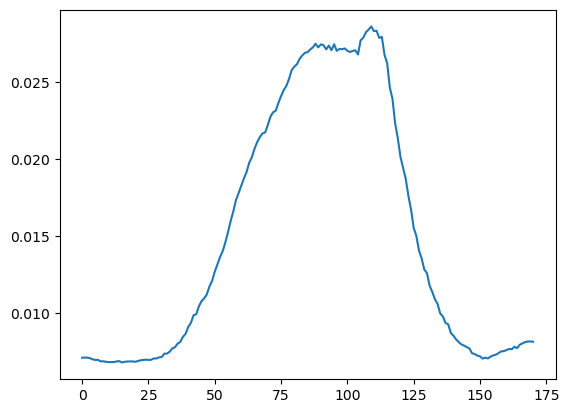

0.028624131944444443

In [91]:

%matplotlib inline
plt.plot(fm_score_list)
plt.show()
max(fm_score_list)